<a href="https://colab.research.google.com/github/nrrajuu/Deep-Learning/blob/main/Financial_Transactions_Data_Forecasting_for_Next_3_Months_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
df=pd.read_csv('/content/sample_data_gl_ml (1).csv')

In [ ]:
df

,VoucherDate,LineSum,company,Account
0,5/31/2009,0.00,0,2383
1,6/1/2009,0.00,0,2383
2,5/31/2010,0.00,0,2383
3,6/1/2010,0.00,0,2383
4,5/31/2011,0.00,0,2383
...,...,...,...,...
1048570,6/22/2021,3711.41,6,2277
1048571,6/22/2021,325.22,6,1791
1048572,6/22/2021,-270.00,6,5342
1048573,6/22/2021,-47.66,6,6142


In [ ]:
def company_wise(company_number):
  df_0=df[df['company']==company_number]
  print(df_0)
  df_0['Total_Balance']=df_0['LineSum']+df_0['Account']
  print(df_0)
  df_0['year'] = pd.DatetimeIndex(df_0['VoucherDate']).year
  df_0['month'] = pd.DatetimeIndex(df_0['VoucherDate']).month
  print(df_0)
  df_0['year']=df_0['year'].astype('str')
  df_0['month']=df_0['month'].astype('str')
  df_0['unique_M_Y']=df_0['month']+'_'+df_0['year']
  print(df_0)
  df_0_R=df_0[['unique_M_Y','Total_Balance']]
  print(df_0_R)
  M_Y_list=df_0_R['unique_M_Y'].unique()
  M_Y_data=[]
  for i in range(len(M_Y_list)):
    inter_df=df_0_R[df_0_R['unique_M_Y']==M_Y_list[i]]
    sum=inter_df['Total_Balance'].sum()
    M_Y=M_Y_list[i]
    df_X=pd.DataFrame(columns=['unique_M_Y','Total_Balance'])
    df_X['unique_M_Y']=[M_Y]
    df_X['Total_Balance']=[sum]
    M_Y_data.append(df_X)
  final_M_Y_df=pd.concat(M_Y_data,axis=0)
  final_M_Y_df.reset_index(inplace=True)
  final_M_Y_df=final_M_Y_df.drop(['index'],axis=1)
  print(final_M_Y_df)

  training_set = final_M_Y_df.iloc[:final_M_Y_df.shape[0]-3, 1:2].values
  test_set = final_M_Y_df.iloc[final_M_Y_df.shape[0]-3:, 1:2].values
  # Feature Scaling
  sc = MinMaxScaler(feature_range = (-1, 1))
  training_set_scaled = sc.fit_transform(training_set)
  # Creating a data structure with 60 time-steps and 1 output
  X_train = []
  y_train = []
  for i in range(2, final_M_Y_df.shape[0]-3):
      X_train.append(training_set_scaled[i-2:i, 0])
      y_train.append(training_set_scaled[i, 0])
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  model = Sequential()
  #Adding the first LSTM layer and some Dropout regularisation
  model.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1))))
  model.add(Dropout(0.2))
  # Adding a second LSTM layer and some Dropout regularisation
  model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
  model.add(Dropout(0.2))
  # Adding a third LSTM layer and some Dropout regularisation
  model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
  model.add(Dropout(0.2))
  # Adding a fourth LSTM layer and some Dropout regularisation
  model.add(Bidirectional(LSTM(units = 50)))
  model.add(Dropout(0.2))
  # Adding the output layer
  model.add(Dense(units = 1))

  # Compiling the RNN
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  # Fitting the RNN to the Training set
  history=model.fit(X_train, y_train, epochs = 50, batch_size = 128)
  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()
  dataset_test = final_M_Y_df.iloc[final_M_Y_df.shape[0]:, 1:2]
  dataset_test.shape
  dataset_train = final_M_Y_df.iloc[:final_M_Y_df.shape[0]-3, 1:2]
  dataset_test = final_M_Y_df.iloc[final_M_Y_df.shape[0]-3:, 1:2]
  dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
  inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
  inputs = inputs.reshape(-1,1)
  inputs = sc.transform(inputs)
  X_test = []
  for i in range(2, 5):
      X_test.append(inputs[i-2:i, 0])
  X_test = np.array(X_test)
  print(X_test.shape)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  print(X_test.shape)
  predicted_stock_price = model.predict(X_test)
  predicted_stock_price = sc.inverse_transform(predicted_stock_price)
  true_y=dataset_test.values
  true_y
  plt.figure(figsize=(7, 3))
  plt.plot(predicted_stock_price, label='Predicted')
  plt.plot(true_y[0:3], label='Orginal')
  plt.xlabel('The Date of the Stock Market')
  plt.ylabel('The Price of the Stock')
  plt.xticks([0,1,2])
  plt.title('The Visualization of Orginal and Predicted Balance Prices for next 3 months')
  plt.legend()


        VoucherDate   LineSum  company  Account
998224   12/31/2020    832.19        5     1213
998225   12/31/2020  30357.88        5     1714
998226   12/31/2020    100.20        5     1774
998227   12/31/2020   2050.65        5     1777
998228   12/31/2020    819.27        5     1831
...             ...       ...      ...      ...
1011377   6/29/2022     -2.23        5     1942
1011378   6/29/2022      2.23        5     2884
1011379   6/29/2022  -4417.50        5     1739
1011380   6/29/2022   4417.50        5     1942
1011381   6/29/2022     17.73        5     2391

[13158 rows x 4 columns]
        VoucherDate   LineSum  company  Account  Total_Balance
998224   12/31/2020    832.19        5     1213        2045.19
998225   12/31/2020  30357.88        5     1714       32071.88
998226   12/31/2020    100.20        5     1774        1874.20
998227   12/31/2020   2050.65        5     1777        3827.65
998228   12/31/2020    819.27        5     1831        2650.27
...             ... 

<ipython-input-176-700e4514f542>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['Total_Balance']=df_0['LineSum']+df_0['Account']
<ipython-input-176-700e4514f542>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['year'] = pd.DatetimeIndex(df_0['VoucherDate']).year
<ipython-input-176-700e4514f542>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

        VoucherDate   LineSum  company  Account  Total_Balance  year  month
998224   12/31/2020    832.19        5     1213        2045.19  2020     12
998225   12/31/2020  30357.88        5     1714       32071.88  2020     12
998226   12/31/2020    100.20        5     1774        1874.20  2020     12
998227   12/31/2020   2050.65        5     1777        3827.65  2020     12
998228   12/31/2020    819.27        5     1831        2650.27  2020     12
...             ...       ...      ...      ...            ...   ...    ...
1011377   6/29/2022     -2.23        5     1942        1939.77  2022      6
1011378   6/29/2022      2.23        5     2884        2886.23  2022      6
1011379   6/29/2022  -4417.50        5     1739       -2678.50  2022      6
1011380   6/29/2022   4417.50        5     1942        6359.50  2022      6
1011381   6/29/2022     17.73        5     2391        2408.73  2022      6

[13158 rows x 7 columns]
        VoucherDate   LineSum  company  Account  Total_Balance

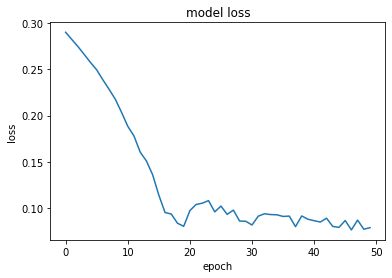

(3, 2)
(3, 2, 1)
1/1 [==============================] - 3s 3s/step


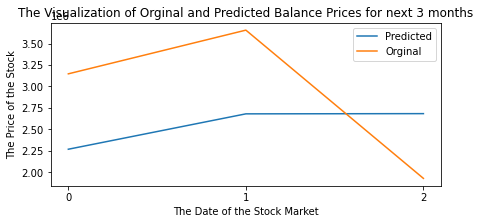

In [ ]:
company_wise(5)